In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from matplotlib import pyplot as plt

In [2]:
iris = load_iris()
print(type(iris))
print(iris.keys())

<class 'sklearn.utils.Bunch'>
dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])


In [3]:
class NeuralNetwork():
    
    def __init__(self, layer_widths, activation_functions, activation_functions_derivatives, loss_func_derivative):
        
        weights = list()
        for i in range(len(layer_widths)-1):
            n, m = layer_widths[i], layer_widths[i+1]
            weights.append(np.empty(shape=(m, n+1)))
        self.W = weights
        self.a = activation_functions
        assert len(self.a) == len(self.W)
        self.ap = activation_functions_derivatives
        assert len(self.a) == len(self.ap)
        self.Lp = loss_func_derivative
    
    def getWeightsGradient(self, x, y):
        n_layers = len(self.W)
        
        #Forward pass.
        stimuli = list()
        affine_transformed_stimuli = list()
        responses = list()
        incoming_stimulus = np.hstack((x, 1))
        for layer in range(n_layers):
            stimuli.append(incoming_stimulus)
            affine_transformation = self.W[layer]
            affine_transformed_stimuli.append(affine_transformation.dot(incoming_stimulus))
            activation_function = self.a[layer]
            response = activation_function(affine_transformed_stimuli[layer])
            responses.append(response)
            incoming_stimulus = np.hstack((response, 1)) #Feed forward response to next layer.
            
        #backward pass.  Earliest layers have worst chain rule prefix due to having more subsequent functions.
        gradients = [None] * n_layers
        loss_derivative = self.Lp(response[-1], y)
        activation_derivative = self.ap[-1](affine_transformed_stimuli[-1])
        chain_rule_for_subsequent_layers = crfsl = loss_derivative * activation_derivative
        gradients[-1] = np.outer(crfsl, stimuli[-1])
        
        for layer in reversed(range(n_layers-1)):
            
            #Do additional calculations for chain rule in subsequent layers
            subsequent_affine_transformation = self.W[layer+1]
            activation_derivative = self.ap[layer](affine_transformed_stimuli[layer])
            #handle the fact that we append ones to hack having to add weights.
            matrix_part_of_affine_transformation = subsequent_affine_transformation[:,:-1]
            crfsl = np.dot(crfsl, matrix_part_of_affine_transformation) * activation_derivative
            
            #Use this for gradient for weights at this layer.
            gradients[layer] = np.outer(crfsl, stimuli[layer])
        
        return gradients
    
    def fit(self, X, y, max_iters=1000, alpha=.2):
        n_obs = X.shape[0]
        #random initialization.
        for i in range(len(self.W)):
            self.W[i] = 1 - 2 * np.random.random(size=self.W[i].shape)
        
        #begin iterative loop.
        for dummy in range(max_iters):
            print("iteration", dummy, end='\r')
            gradients = list()
            for W in self.W:
                gradients.append(np.empty((W.shape[0], W.shape[1], n_obs)))
            #for each observation, get weights gradient -- TODO: parallelize.  A ton.
            for i, x in enumerate(X):
                grads = self.getWeightsGradient(x, y[i])
                for j in range(len(self.W)):
                    gradients[j][:,:,i] = grads[j]
            #find average of weights gradient, and take step determined by alpha.
            for j in range(len(self.W)):
                self.W[j] -= alpha * gradients[j].mean(axis=-1)
            #if max change less than eps, then break
        
        #save weights.
        return
        
    def predict_proba(self, X):
        if(len(X.shape) == 1):
            X = X.reshape((1, -1))
        probs = np.empty(X.shape[0])
        for i in range(X.shape[0]):
            x = X[i]
            n_layers = len(self.W)
            incoming_stimulus = np.hstack((x, 1))
            response = None
            for layer in range(n_layers):
                affine_transformation = self.W[layer]
                affine_transformed_stimuli = affine_transformation.dot(incoming_stimulus)
                activation_function = self.a[layer]
                response = activation_function(affine_transformed_stimuli)
                if layer + 1 < n_layers:
                    incoming_stimulus = np.hstack((response, 1)) #Feed forward response to next layer.
            probs[i] = response
        return probs
            
            
        

In [4]:
"""ReLu = lambda x : np.maximum(0, x)
ReLuDerivative = lambda x : 1 * (x >= 0)
sigmoid = lambda x : 1 / (1 + np.exp(-x))
sigmoidDerivative = lambda x : np.exp(-x) / (1 + np.exp(-x))**2 #- 1 / (1 + np.exp(-x))**2 * np.exp(-x) * -1
loss = lambda p, y : -(y * np.log(p) + (1-y)*np.log(1-p))
loss_differentiated_wrt_p = lambda p, y : -(y/p-(1-y)/(1-p))
n_features = 10
test = NeuralNetwork([n_features, 5, 3, 1], 
                     [ReLu, ReLu, sigmoid],
                     [ReLuDerivative, ReLuDerivative, sigmoidDerivative],
                     loss_differentiated_wrt_p
                    )
for x in np.eye(n_features):
    for y in [0, 1]:
        print("Weights gradients with x ==", x, "and y ==", y)
        grads = test.getWeightsGradient(x, y)
        print("number of returned gradients:", len(grads))
        print("shapes:")
        for g in grads:
            print(g.shape)
        print()
        """
#No longer needed.
print()

In [5]:
#Debug randomness right now.
np.random.seed(42)

ReLu = lambda x : np.maximum(0, x)
ReLuDerivative = lambda x : 1 * (x >= 0)
sigmoid = lambda x : 1 / (1 + np.exp(-x))
sigmoidDerivative = lambda x : np.exp(-x) / (1 + np.exp(-x))**2 #- 1 / (1 + np.exp(-x))**2 * np.exp(-x) * -1
loss = lambda p, y : -(y * np.log(p) + (1-y)*np.log(1-p))
loss_differentiated_wrt_p = lambda p, y : -(y/p-(1-y)/(1-p))
X, y = iris.data, iris.target
is_setosa = (y==0)*1
n_features = X.shape[1]
test = NeuralNetwork([n_features, 5, 3, 1], 
                     [ReLu, ReLu, sigmoid],
                     [ReLuDerivative, ReLuDerivative, sigmoidDerivative],
                     loss_differentiated_wrt_p
                    )
test.fit(X, is_setosa, max_iters=1000)
print()
test.predict_proba(X)

#print()

iteration 99913 24 26 27 37 39 4050 53 54 64 66 67 77 79 80 93 94 104 106 107 117 119 120 130 132 133 143 145 146 156 159 160 170 172 173 183 185 186 197 201 213 215 216 228 230 231 242 245 246 257 259 272 274 275 286 289 290 301 304 305 316 318 320 331 333 334 346 348 349 360 363 364 375 378 379 390 393 394 407 409 421 422 423 436 437 438 451 452 453 467 480 482 484 495 496 499 510 511 514 525 526 529 540 544 555 557 559 571 574 586 588 602 603 605 617 618 620 633 636 648 651 662 664 665 677 679 694 695 707 710 722 725 737 740 756 769 771 786 800 801 815 816 830 831 845 846 859 861 874 876 891 923 955 970 984


array([9.84280982e-01, 9.84280982e-01, 9.84280982e-01, 9.84280982e-01,
       9.84280982e-01, 9.84280982e-01, 9.84280982e-01, 9.84280982e-01,
       9.84280982e-01, 9.84280982e-01, 9.84280982e-01, 9.84280982e-01,
       9.84280982e-01, 9.84280982e-01, 9.84280982e-01, 9.84280982e-01,
       9.84280982e-01, 9.84280982e-01, 9.84280982e-01, 9.84280982e-01,
       9.84280982e-01, 9.84280982e-01, 9.84280982e-01, 9.84280982e-01,
       9.84280982e-01, 9.84280982e-01, 9.84280982e-01, 9.84280982e-01,
       9.84280982e-01, 9.84280982e-01, 9.84280982e-01, 9.84280982e-01,
       9.84280982e-01, 9.84280982e-01, 9.84280982e-01, 9.84280982e-01,
       9.84280982e-01, 9.84280982e-01, 9.84280982e-01, 9.84280982e-01,
       9.84280982e-01, 9.80100411e-01, 9.84280982e-01, 9.84280982e-01,
       9.84280982e-01, 9.84280982e-01, 9.84280982e-01, 9.84280982e-01,
       9.84280982e-01, 9.84280982e-01, 3.43447478e-05, 4.34151871e-05,
       8.68440132e-06, 1.28573034e-04, 1.92834658e-05, 5.35813643e-05,
      

In [6]:
print(np.round(abs(is_setosa - test.predict_proba(X))*100))

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


So, it's 98% sure the setosas are setosas, and 99% sure the things that aren't setosas aren't setosas.  Sweet.  It worked!

# Try with noisy sine function.

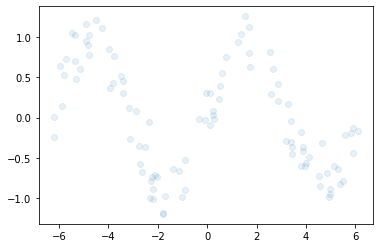

In [7]:
X = np.random.uniform(-2*np.pi, 2*np.pi, size=(100,1))
signal = np.sin(X.ravel())
noise = np.random.normal(0, .25, size=signal.shape)
y = signal+noise
plt.scatter(X.ravel(), y, alpha=.1)

In [8]:
n_features = 1
ReLu = lambda x : np.maximum(0, x)
ReLuDerivative = lambda x : 1 * (x >= 0)
identity = lambda x : x
identityDerivative = lambda x : 1
#sigmoid = lambda x : 1 / (1 + np.exp(-x))
#sigmoidDerivative = lambda x : np.exp(-x) / (1 + np.exp(-x))**2 #- 1 / (1 + np.exp(-x))**2 * np.exp(-x) * -1
loss = lambda p, y : (p-y)**2
loss_differentiated_wrt_p = lambda p, y : 2*(p-y)
n_features = X.shape[1]
test = NeuralNetwork([n_features, 100, 100, 100, 1], 
                     [ReLu, ReLu, ReLu, identity],
                     [ReLuDerivative, ReLuDerivative, ReLuDerivative, identityDerivative],
                     loss_differentiated_wrt_p
                    )
X_trans = X/(2*np.pi)
test.fit(X_trans, y, max_iters=1000, alpha=.0002)
print()
y_hat = test.predict_proba(X_trans)
print(y_hat)

iteration 999 7 9 14 15 16 22 28 30 37 42 43 44 51 56 58 64 65 71 72 77 79 86 91 92 99 105 106 112 113 120 125 127 132 134 139 141 148 153 154 161 167 168 173 175 189 203 210 217 231 252 266 287 330 365 400 421 428 435 442 449 456 463 484 497 504 517 524 531 537 544 572 578 585 592 599 606 613 642 656 677 683 690 697 704 711 717 724 731 738 745 773 801 808 815 822 836 843 850 856 863 870 877 884 891 898 905 912 926 940 954 968 989
[ 0.18359081  0.46379197  0.73819921 -0.51563776 -0.08024531 -0.61604809
 -0.65442713  1.01534998 -0.63331559  0.83636437  0.6546267   0.51049939
 -0.83738419 -1.1720761  -0.12365745 -0.48666019 -0.9178959  -0.27777975
  0.3964713   0.90467982 -0.2961402   0.76560294 -0.48871633 -0.06050193
  0.63525232  0.26588853 -0.39518917  0.2280653   0.18179265 -0.05384056
  0.76372768 -0.93260814  0.90967621 -0.62388504  0.97174605 -0.83930647
  0.72486439 -0.66222395 -0.83558951  0.17963615  0.81244583 -0.64579877
 -0.12552413  0.90893335  0.21369868  0.0178393   0.70

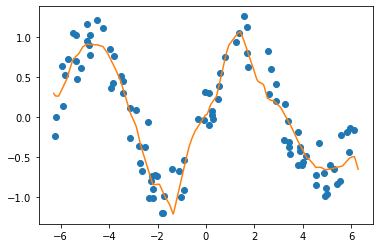

In [9]:
plt.scatter(X.ravel(), y)
t = np.linspace(-2*np.pi, 2*np.pi, 1000)
t_trans = t / (2*np.pi)
y_hat = test.predict_proba(t_trans.reshape((-1, 1)))
plt.plot(t, y_hat, color='C1')
#plt.plot